# Job title Classification by industry 

# Setup Enviroment 

In [84]:
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moust\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moust\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load dataset

In [85]:
df = pd.read_csv("Job titles and industries.csv")

In [86]:
df.head()

,job title,industry
0,technical support and helpdesk supervisor - co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT


In [87]:
df.shape

(8586, 2)

# Cleaning the data 

check duplicates

In [88]:
print(df['job title'].duplicated().value_counts())

True     4696
False    3890
Name: job title, dtype: int64


we have 4696 duplicates in our job titles

In [89]:
df=df.drop_duplicates(subset="job title",keep='last')

remove all special characters,numbers , stop english words or html tags got from scraping from the job title 

In [90]:
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

df['job title']=df['job title'].map(lambda s:preprocess(s)) 

In [91]:
df.sample(5)['job title']

7747                         help desk engineer
8210              advertising account executive
3910    test automation engineer global company
120                       java support engineer
7665               astronomy physics instructor
Name: job title, dtype: object

# Imbalancing investigation

In [92]:
df['industry'].value_counts()

IT             1490
Marketing      1196
Education       941
Accountancy     263
Name: industry, dtype: int64

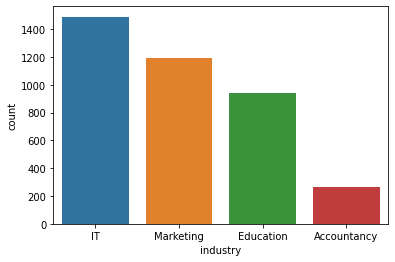

In [93]:
ax = sns.countplot(x='industry' , data=df)
plt.show()

seems like we have very few data points of 'Accountancy' cateogry. We thought that removing duplicate may solve help but it didn't

# Fix Imbalancing

As we can see that there is a huge gap between (IT,Marking) and Accountancy we can <strong> Undersample</strong> the class with the max number of records which in this case (IT)

In [94]:
up_sample_count=sum([df['industry'].value_counts()['Marketing'],df['industry'].value_counts()['Education'],df['industry'].value_counts()['Accountancy']])/3

In [95]:
it_class = df[df['industry'] == 'IT'].index
random_it_class = np.random.choice(it_class , int(up_sample_count) , replace = False)

under_sample_indicies = np.concatenate([random_it_class , df[df['industry'] == 'Marketing'].index 
                                        , df[df['industry'] == 'Education'].index  ,
                                        df[df['industry'] == 'Accountancy'].index  ])
df = df.loc[under_sample_indicies]

In [96]:
df.value_counts()

job title                            industry 
teacher                              Education    10
year teacher                         Education     6
software developer                   IT            5
net developer                        IT            4
developer                            IT            4
                                                  ..
ppc marketing executive              Marketing     1
ppc manager retail marketing agency  Marketing     1
ppc manager                          Marketing     1
ppc executive                        Marketing     1
                                     Education     1
Length: 3077, dtype: int64

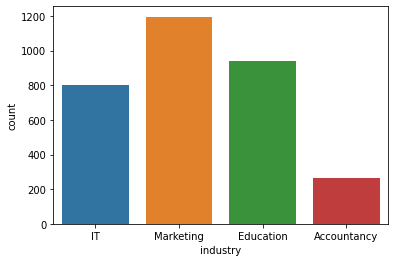

In [97]:
ax = sns.countplot(x='industry' , data=df)
plt.show()

# Vectorize job title

In [98]:
tfidf = TfidfVectorizer(sublinear_tf= True ,
                        min_df = 5 ,
                        norm = 'max' ,
                        ngram_range = (1,2) ,
                        stop_words = 'english')
features = tfidf.fit_transform(df['job title']).toarray()

In [99]:
X_train , X_test , y_train , y_test = train_test_split(df['job title'] , df['industry'] , random_state= 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Try Models

## SVM 

In [100]:
svc_model = LinearSVC().fit(X_train_tfidf , y_train)

In [101]:
y_pred = svc_model.predict(count_vect.transform(X_test))

### Evaluate

In [102]:
print(metrics.classification_report(y_test , y_pred ,target_names=df['industry'].unique()))

              precision    recall  f1-score   support

          IT       0.87      0.82      0.84        71
   Marketing       0.95      0.88      0.91       237
   Education       0.83      0.91      0.87       209
 Accountancy       0.88      0.88      0.88       283

    accuracy                           0.88       800
   macro avg       0.88      0.87      0.88       800
weighted avg       0.89      0.88      0.88       800



In [103]:
metrics.accuracy_score(y_test , y_pred)

0.8825

## Multinomial  Naive Bayes

In [104]:
mnn = MultinomialNB().fit(X_train_tfidf , y_train)

In [105]:
y_predict = mnn.predict(count_vect.transform(X_test))

### Evaluate

In [106]:
print(metrics.classification_report(y_test , y_predict ,target_names=df['industry'].unique()))

              precision    recall  f1-score   support

          IT       0.92      0.65      0.76        71
   Marketing       0.97      0.87      0.92       237
   Education       0.88      0.85      0.86       209
 Accountancy       0.79      0.93      0.85       283

    accuracy                           0.86       800
   macro avg       0.89      0.82      0.85       800
weighted avg       0.87      0.86      0.86       800



In [107]:
metrics.accuracy_score(y_test , y_predict)

0.865

## Conclusion

we have seen that svm has better accuracy regarding classifing the class 

In [112]:
from joblib import dump, load
filename = 'industry_classifier_nlp\svc_model.joblib.pkl'
vec_file = 'industry_classifier_nlp\vec.joblib.pkl'
g1= dump(svc_model, filename, compress=9)
g2= dump(count_vect, vec_file, compress=9)